In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad

from background_models import phi_g_egb_fermi, phi_e_bg_dampe
from constants import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from constants import e_low_aniso_ams, e_high_aniso_ams, aniso_ams, rho_max
from constants import dampe_excess_bin_low, dampe_excess_bin_high, dampe_bins
from constants import rho_earth, plot_obs, t_diff, t_loss, fermi_psf
from constants import speed_of_light, kpc_to_cm, dampe_excess_iflux
from constants import fermi_pt_src_sens_0_0, fermi_pt_src_sens_120_45
from utilities import D, lambda_prop, mantissa_exp
from finite_clump_vectorized import phi_e, rho_s_dampe, phi_g
from finite_clump_vectorized import line_width_constraint, mass
from finite_clump_vectorized import rho as density_profile
from finite_clump_vectorized import anisotropy_integrated
from pointlike_clump import phi_e_dampe as phi_e_dampe_pt
from pointlike_clump import phi_e as phi_e_pt
from pointlike_clump import lum_dampe as lum_dampe_pt
from pointlike_clump import line_width_constraint as line_width_constraint_pt
from pointlike_clump import anisotropy_integrated as aniso_int_pt
from pointlike_clump import anisotropy_differential as aniso_diff_pt

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
clump_cols = [colors[0]] + colors[2:]
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"
# Significance used for line width constraint
n_sigma = 3.

## Local density enhancement

This doesn't make mathematical sense. The more meaningful thing to do would be to marginalize over the parts of the $(d, r_s)$ plane that aren't ruled out by line width and extended/point-source gamma-ray constraints.

In [3]:
from scipy.interpolate import interp2d

In [4]:
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

In [7]:
gamma = 1.
halo = "nfw"

In [106]:
def plot_rho_rel_hist(gamma, halo, ax, color, bins=np.linspace(0, 60, 15)):
    base_path = 'data/{}_gamma_{}/'.format(halo, gamma)
    # Load local density enhancement
    rho_rel = np.loadtxt("{}rho_rel.csv".format(base_path), delimiter=",")
    # Load probabilities
    dist_pr, r_s_pr, pr = np.loadtxt(
        "{}{}/{}_gamma_{:.2f}.csv".format(pr_base_path, halo, halo, gamma), delimiter=",").T
    dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1).T
    r_s_pr = r_s_pr.reshape(dist_pr.shape).T
    pr = pr.reshape(dist_pr.shape).T
    
    assert np.all(dist_pr == dist_mg)
    assert np.all(r_s_pr == r_s_mg)

    ax.hist(rho_rel.flatten(), weights=pr.flatten() / pr.sum(), density=True,
            bins=bins, histtype="step", linewidth=2, color=color,
            label=r"$\gamma_{\mathrm{%s}} = %g$" % (halo, gamma))

    print("gamma_{}={}:\tE[rho_rel] = {}".format(halo, gamma, (rho_rel * pr).sum() / pr.sum()))

gamma_nfw=0.5:	E[rho_rel] = 20.3398730639
gamma_nfw=1.0:	E[rho_rel] = 20.9549315292
gamma_exp=0.52:	E[rho_rel] = 14.0745015679
gamma_exp=0.74:	E[rho_rel] = 13.0495347524
gamma_exp=1.08:	E[rho_rel] = 9.71620808587


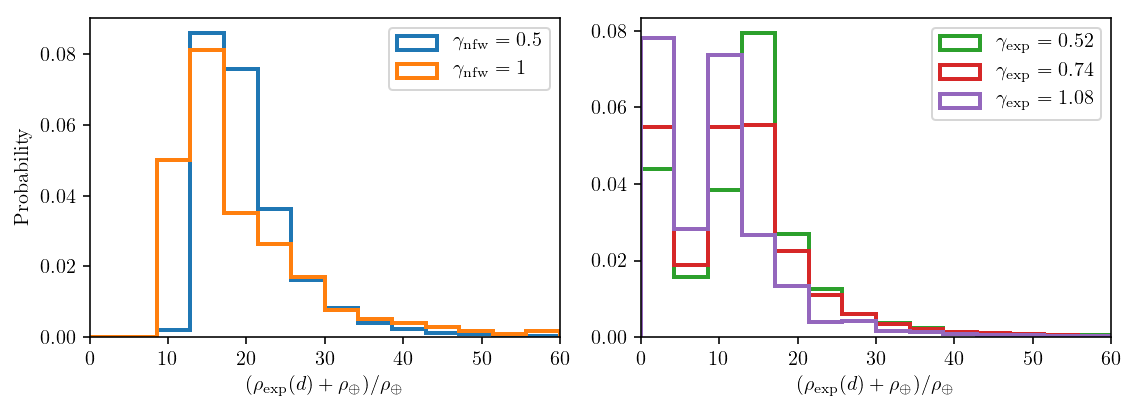

In [108]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 3))
bins = np.linspace(0, 60, 15)
counter = 0

ax = axes[0]
halo = "nfw"
for gamma in [0.5, 1.]:
    plot_rho_rel_hist(gamma, halo, ax, colors[counter])
    counter += 1
ax.set_xlim(bins[[0, -1]])
ax.set_xlabel(r"$(\rho_{\mathrm{exp}}(d) + \rho_\oplus) / \rho_\oplus$")
ax.set_ylabel("Probability")
ax.legend()

ax = axes[1]
halo = "exp"
for gamma in [0.52, 0.74, 1.08]:
    plot_rho_rel_hist(gamma, halo, ax, colors[counter])
    counter += 1
ax.set_xlabel(r"$(\rho_{\mathrm{exp}}(d) + \rho_\oplus) / \rho_\oplus$")
ax.legend()

fig.tight_layout()

## Profile comparison
Not particularly interesting.

In [2]:
gamma_exp = 0.74
gamma_nfw = 1.0
dist = 5e-2
r_s = np.logspace(-2, 2, 3)

In [3]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

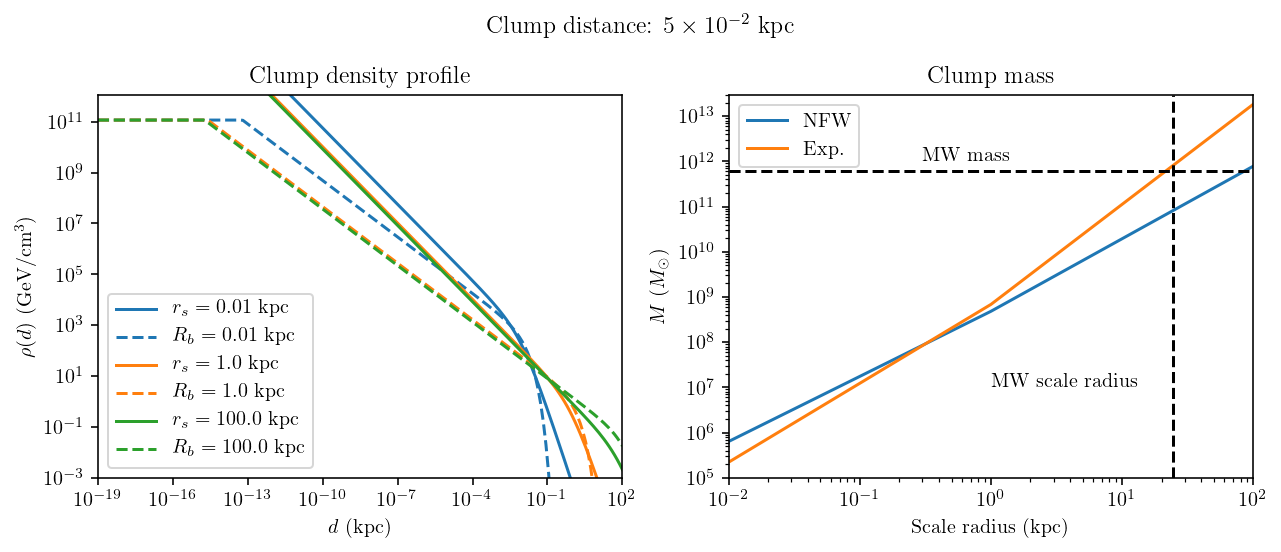

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
rs = np.logspace(-19, 2, 200)
for r, rho_nfw, rho_exp, c in zip(r_s, rho_s_nfw, rho_s_exp, colors):
    ax.plot(rs, density_profile(rs, r, rho_nfw, gamma_nfw, "nfw"),
            color=c, label=r"$r_s = {}$ kpc".format(r))
    ax.plot(rs, density_profile(rs, r, rho_exp, gamma_exp, "exp"),
            '--', color=c, label="$r_b = {}$ kpc".format(r))

# ax.axvline(dist, color='k', linestyle='--', alpha=0.3)
# ax.axvline(1. * np.pi/180 * dist, color='k', linestyle='--')

ax.legend()
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-3, rho_max*10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$d$ (kpc)")
ax.set_ylabel(r"$\rho(d)$ (GeV/cm$^3$)")
ax.set_title("Clump density profile")

ax = axs[1]
ax.plot(r_s, mass(r_s, rho_s_nfw, gamma_nfw, "nfw"), label="NFW")
ax.plot(r_s, mass(r_s, rho_s_exp, gamma_exp, "exp"), label="Exp.")
# Milky Way mass
ax.axhline(6e11, color='k', linestyle='--')
ax.text(3e-1, 1e12, "MW mass")
# MW scale radius
ax.axvline(24.42, color='k', linestyle='--')
ax.text(1e0, 1e7, "MW scale radius")

ax.legend()
ax.set_xlim(r_s[[0, -1]])
ax.set_ylim(1e5, 3e13)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Scale radius (kpc)")
ax.set_ylabel(r"$M$ ($M_\odot$)")
ax.set_title("Clump mass")

fig.suptitle(r"Clump distance: $5\times10^{-2}$ kpc")
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

## Making sure stationarity assumption is valid

This shows the clump doesn't travel far relative to its scale radius in a propagation time. The black line is the distance traveled during one propagation time as a function of clump distance. Scale radii in the orange region are smaller than we consider. Clump distances in the blue region are ruled out by line width. The part of the black line that is not excluded by line width is excluded by gamma ray constraints (not shown on this plot).

Text(0,0.5,'$r_{\\mathrm{scale}}$ (kpc)')

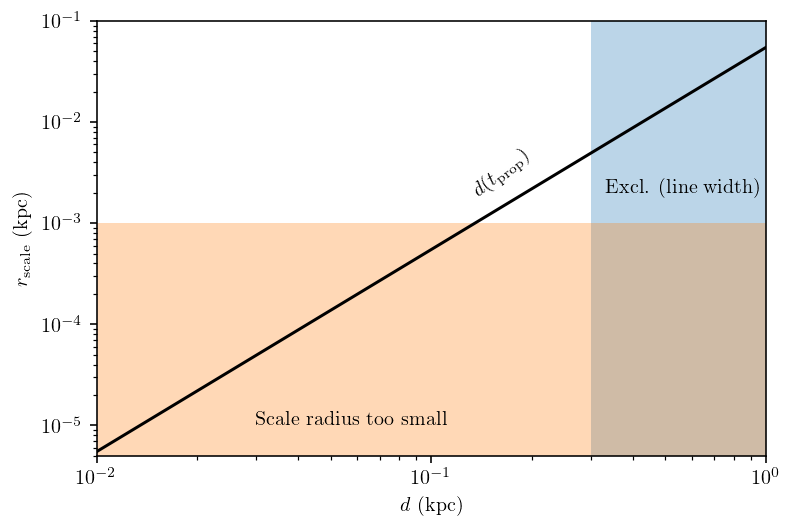

In [5]:
dist = np.logspace(-3, 0, 100)
r_s = np.logspace(-3, 1, 100)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

t_prop = np.min([t_diff(dampe_excess_bin_high, dist_mg),
                 t_loss(dampe_excess_bin_high) * np.ones_like(dist_mg)],
                axis=0)


# Distance traveled by clump during one propagation time
plt.loglog(dist, 1e-3*speed_of_light/kpc_to_cm*t_prop[-1, :], 'k')
plt.text(1.3e-1, 4e-3, r"$d(t_{\mathrm{prop}})$", rotation=38)

# Shade distances ruled out by line width
plt.fill_betweenx([1e-7, 1e-1], 3e-1, 3e0, alpha=0.3)
plt.text(3.3e-1, 2e-3, "Excl. (line width)")
# Shade scale radii not considered in our work
plt.fill_between([1e-2, 3e0], 1e-7, 1e-3, alpha=0.3)
plt.text(3e-2, 1e-5, "Scale radius too small")

plt.xlim(1e-2, 1e0)
plt.ylim(5e-6, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{scale}}$ (kpc)")

## Propagation timescales

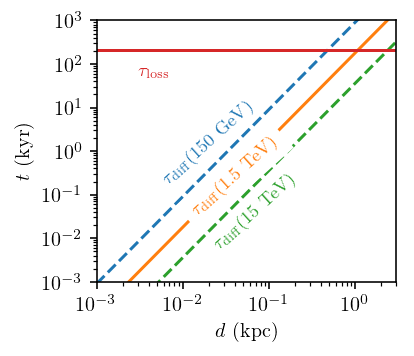

In [2]:
d = np.logspace(-3, np.log10(3e0), 200)
s_to_yr = 1./(365e3 * 24*60*60)

plt.figure(figsize=(3, 2.6))
plt.loglog(d, s_to_yr*t_diff(1.5e2, d), '--', color=colors[0])
plt.text(2e-2, 1.5e0, r"$\tau_{\mathrm{diff}}(150 ~ \mathrm{GeV})$",
         rotation=42, ha="center", va="center", color=colors[0], fontsize=9)

plt.loglog(d, s_to_yr*t_diff(dampe_excess_bin_high, d), color=colors[1])
plt.text(4e-2, 2.6e-1, r"$\tau_{\mathrm{diff}}(1.5 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[1], fontsize=9,
         backgroundcolor="w")

plt.loglog(d, s_to_yr*t_diff(1.5e4, d), '--', color=colors[2])
plt.text(7e-2, 4e-2, r"$\tau_{\mathrm{diff}}(15 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[2], fontsize=9)

plt.loglog(d, s_to_yr*np.ones_like(d)*t_loss(dampe_excess_bin_high),
           color=colors[3])
plt.text(3e-3, 5e1, r"$\tau_{\rm loss}$", color=colors[3], fontsize=9)

plt.autoscale(axis="x", tight=True)
plt.ylim(1e-3, 1e3)
# plt.title("CRE propagation timescales", fontsize=11)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$t$ (kyr)")
# plt.legend()

plt.tight_layout()
plt.savefig("figures/propagation_timescales.pdf")

## $e^\pm$ anisotropy

In [9]:
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 5)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)
e_low, e_high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]

In [16]:
lum_pt = lum_dampe_pt(dist)
lw_pt = line_width_constraint_pt(dist, lum_pt, n_sigma)
aniso_int = aniso_int_pt(e_low, e_high, dist, lum_pt)

In [17]:
rho_s_cl = rho_s_dampe(dist_mg, r_s_mg, gamma=1.08, halo="exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


In [20]:
anisos_exp = anisotropy_integrated(
    e_low, e_high, dist_mg, r_s_mg, rho_s_cl, gamma_exp, "exp", delta_d_rel=1e-4)

finite_clump_vectorized.py:143: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  epsabs=0, epsrel=epsrel, limit=limit)


In [21]:
os.system("say 'Done'")

0

Integrated anisotropy for a point-like clump

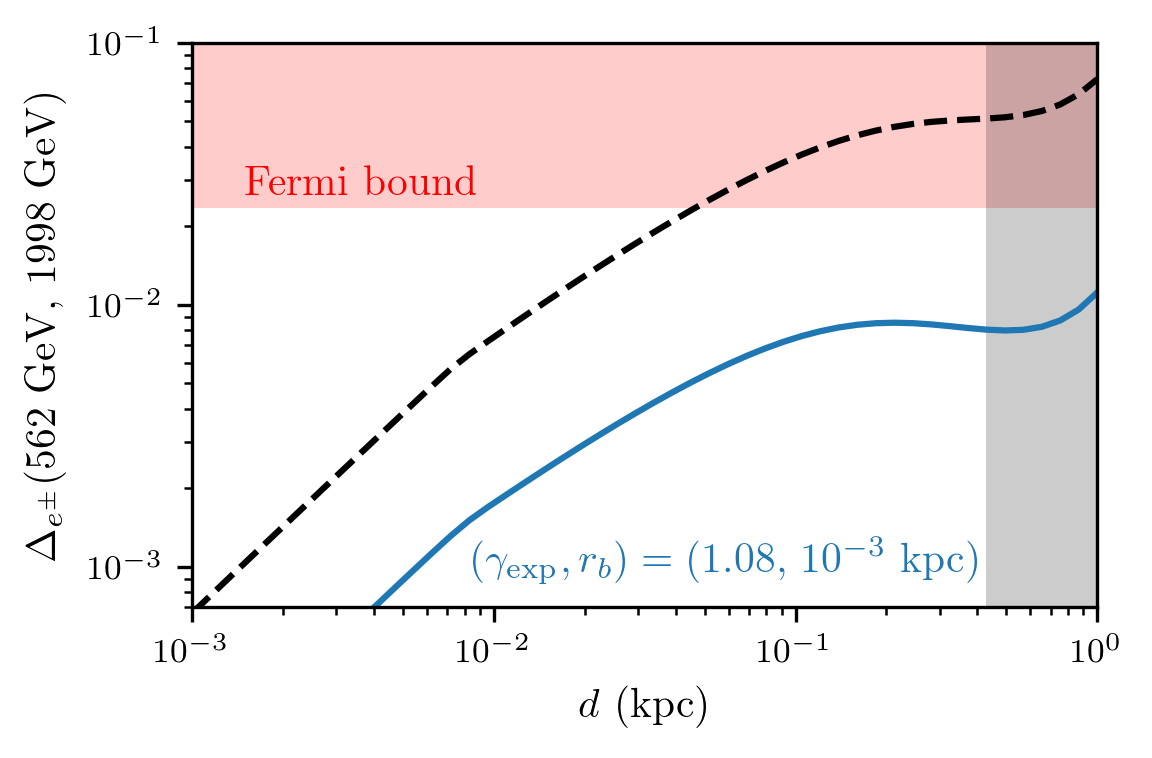

In [44]:
plt.figure(figsize=(4, 2.7))
plt.xlim(dist[[0, -1]])
plt.ylim(7e-4, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\Delta_{e^\pm}(562~\mathrm{GeV},\, 1998~\mathrm{GeV})$")

plt.loglog(dist, aniso_int, '--k')
plt.plot(dist, anisos_exp[0], label="{}".format(r_s[0]))

plt.axhspan(aniso_fermi[-1], 1e-1, linestyle='-', color='r', alpha=0.2, linewidth=0)
plt.axvspan(dist[np.where(lw_pt > n_sigma)[0][0]], dist[-1],
            color='k', alpha=0.2, linewidth=0)
plt.text(1.5e-3, 2.6e-2, "Fermi bound", color="r", fontsize=10)
plt.text(8.5e-3, 9e-4,
         r"$(\gamma_{\mathrm{exp}}, r_b) = (1.08,\, 10^{%i}~\mathrm{kpc})$" %
         mantissa_exp(r_s[0])[1], color=colors[0], fontsize=10)

plt.tight_layout()
plt.savefig("figures/aniso_int_pt.pdf")

## $e^\pm$ spectra and density profiles

Compute clump normalizations and spectra

In [5]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1

In [6]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [7]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [8]:
e_epm = np.linspace(500, 2000, 500)

phi_e_exp = []
for r, rho in zip(r_s, rho_s_exp):
    phi_e_exp.append(
        phi_e(e_epm, dist, r, rho, gamma_exp, "exp"))
phi_e_exp = np.array(phi_e_exp)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


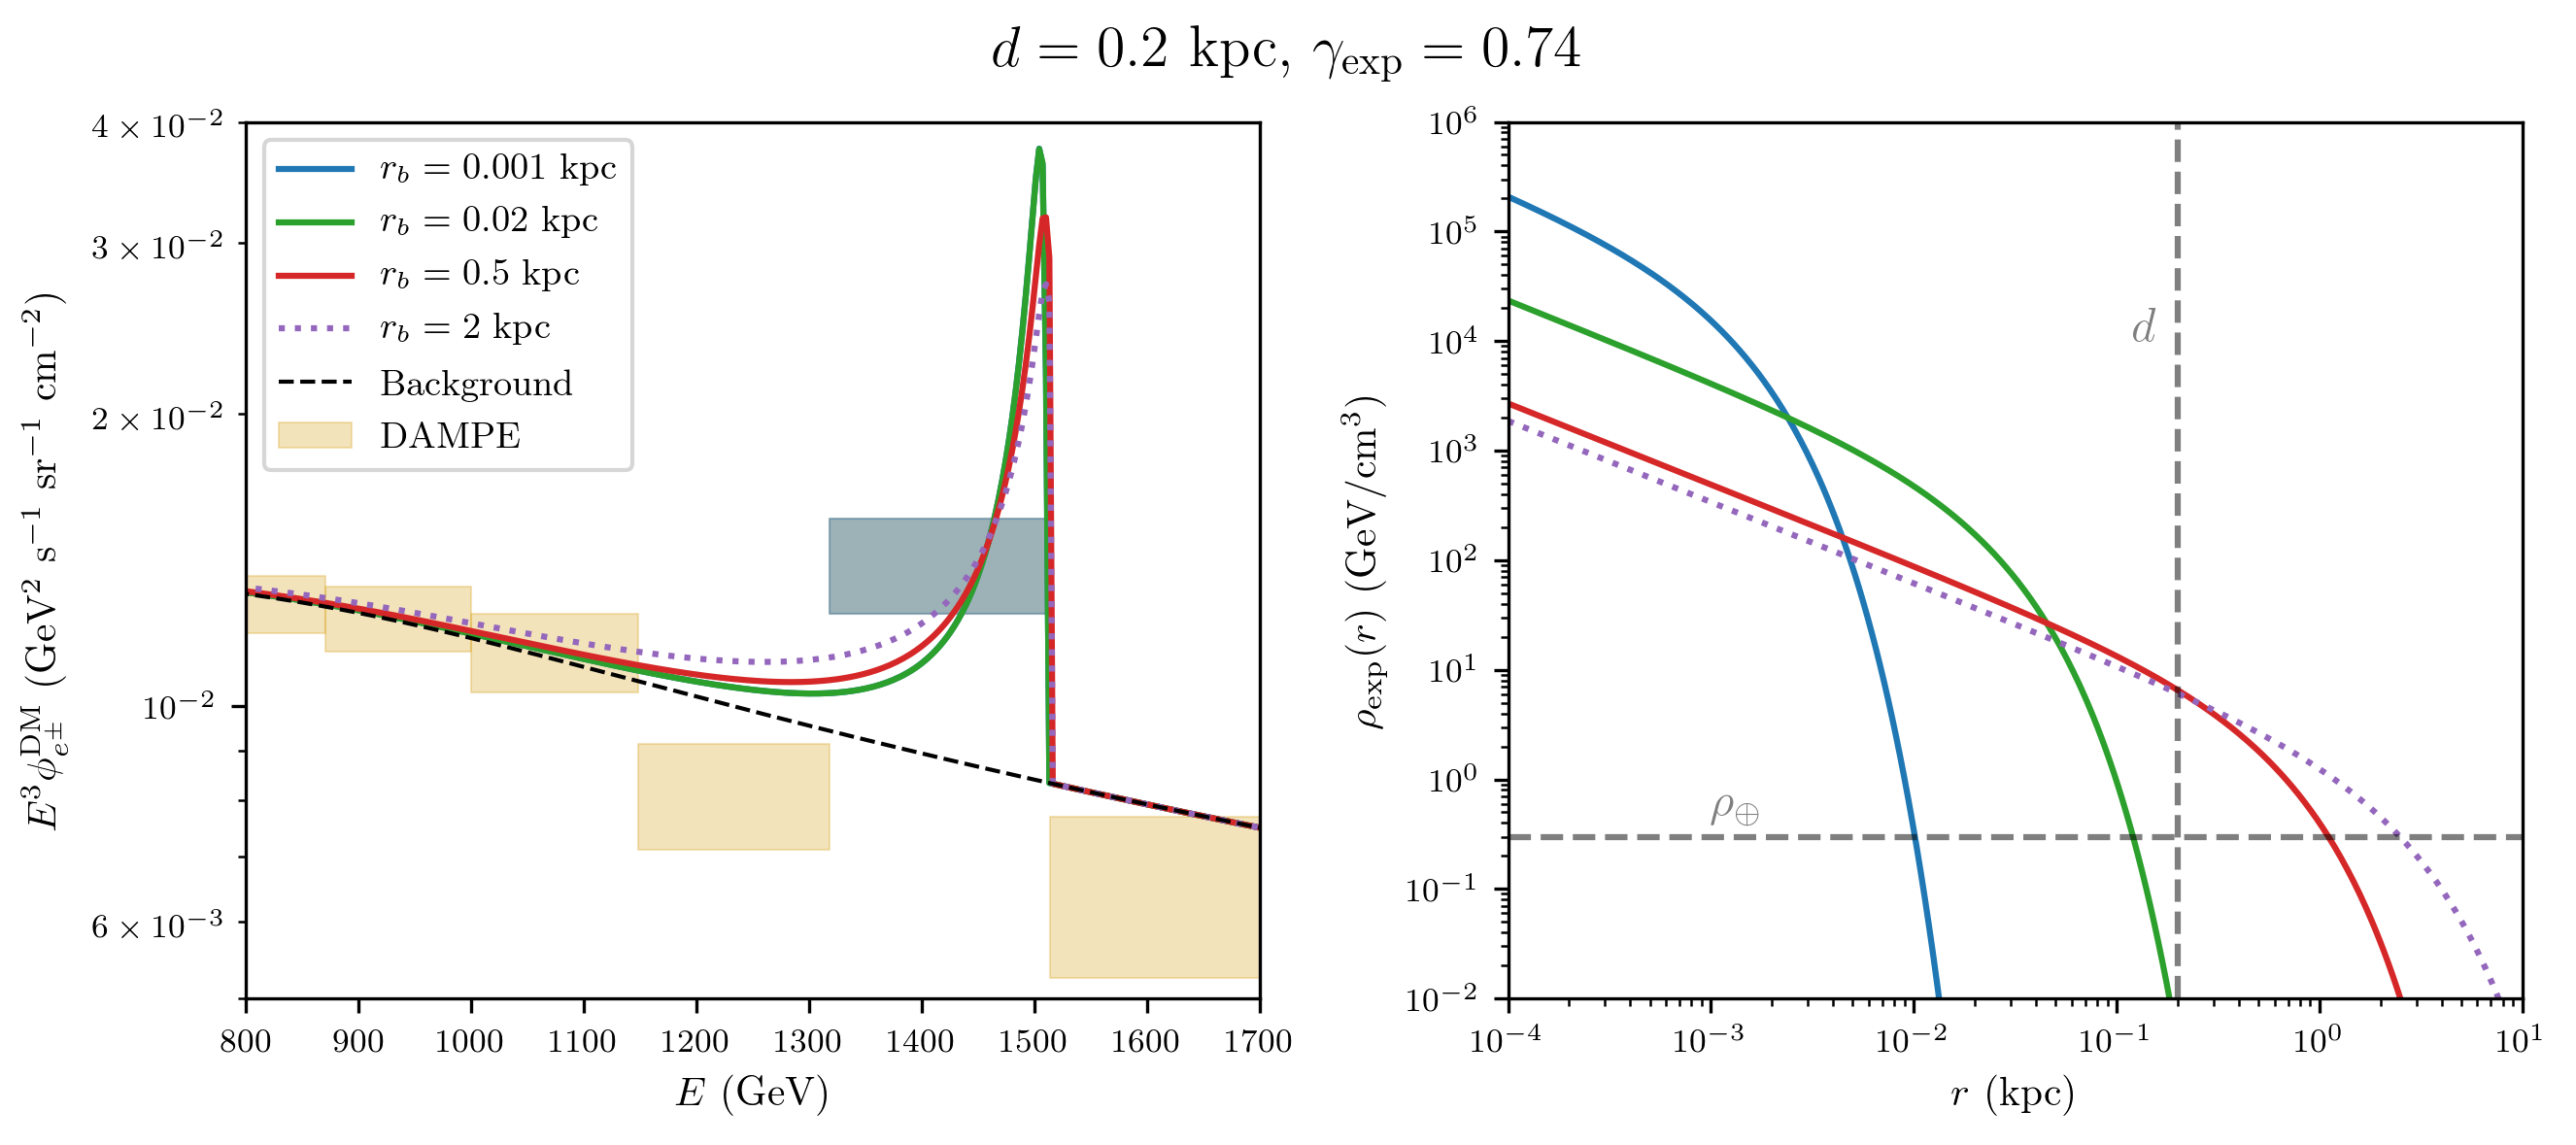

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# e+/e- fluxes
ax = axs[0]
# DAMPE observations
power = 3
plot_obs(power, ax, True)
# DM
for phi, r, lw_ex, c in zip(phi_e_exp, r_s, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    if int(r) == r:
        label = r"$r_b = {}$ kpc".format(int(r))
    else:
        label = r"$r_b = {}$ kpc".format(r)
    
    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
            color=c, linestyle=linestyle, label=label)
    
# Background only
ax.plot(e_epm, e_epm**3 * phi_e_bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")
# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
ax.set_ylim(5e-3, 4e-2)  # power=3
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3 \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Halo profiles
ax = axs[1]
rs = np.logspace(-4, 1, 500)
for r, rho, lw_ex, c in zip(r_s, rho_s_exp, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"
    ax.loglog(rs, density_profile(rs, r, rho, gamma_exp, "exp"),
              color=c, linestyle=linestyle)
    
    rho_cl = density_profile(dist, r, rho, gamma_exp, "exp")

ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
ax.text(1.2e-1, 1e4, r"$d$", alpha=0.5)
ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
ax.text(1e-3, 4e-1, r"$\rho_\oplus$", alpha=0.5)
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-2, 1e6)
ax.set_xlabel(r"$r$ (kpc)")
ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

## $\gamma$-ray spectra

Fermi broadband flux sensitivity: max flux of a power law source at the detection threshold for any power law. From [here](http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm).

### Figure for section 4

In [10]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1

th_maxes = np.array([fermi_psf, 1 * np.pi / 180])

In [11]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [12]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [13]:
e_g = np.linspace(30, 2000, 500)

phi_g_exp = {th: [] for th in th_maxes}
for th in th_maxes:
    for r, rho in zip(r_s, rho_s_exp):
        phi_g_exp[th].append(
            phi_g(e_g, dist, r, rho, gamma_exp, "exp", th_max=th))
    phi_g_exp[th] = np.array(phi_g_exp[th])

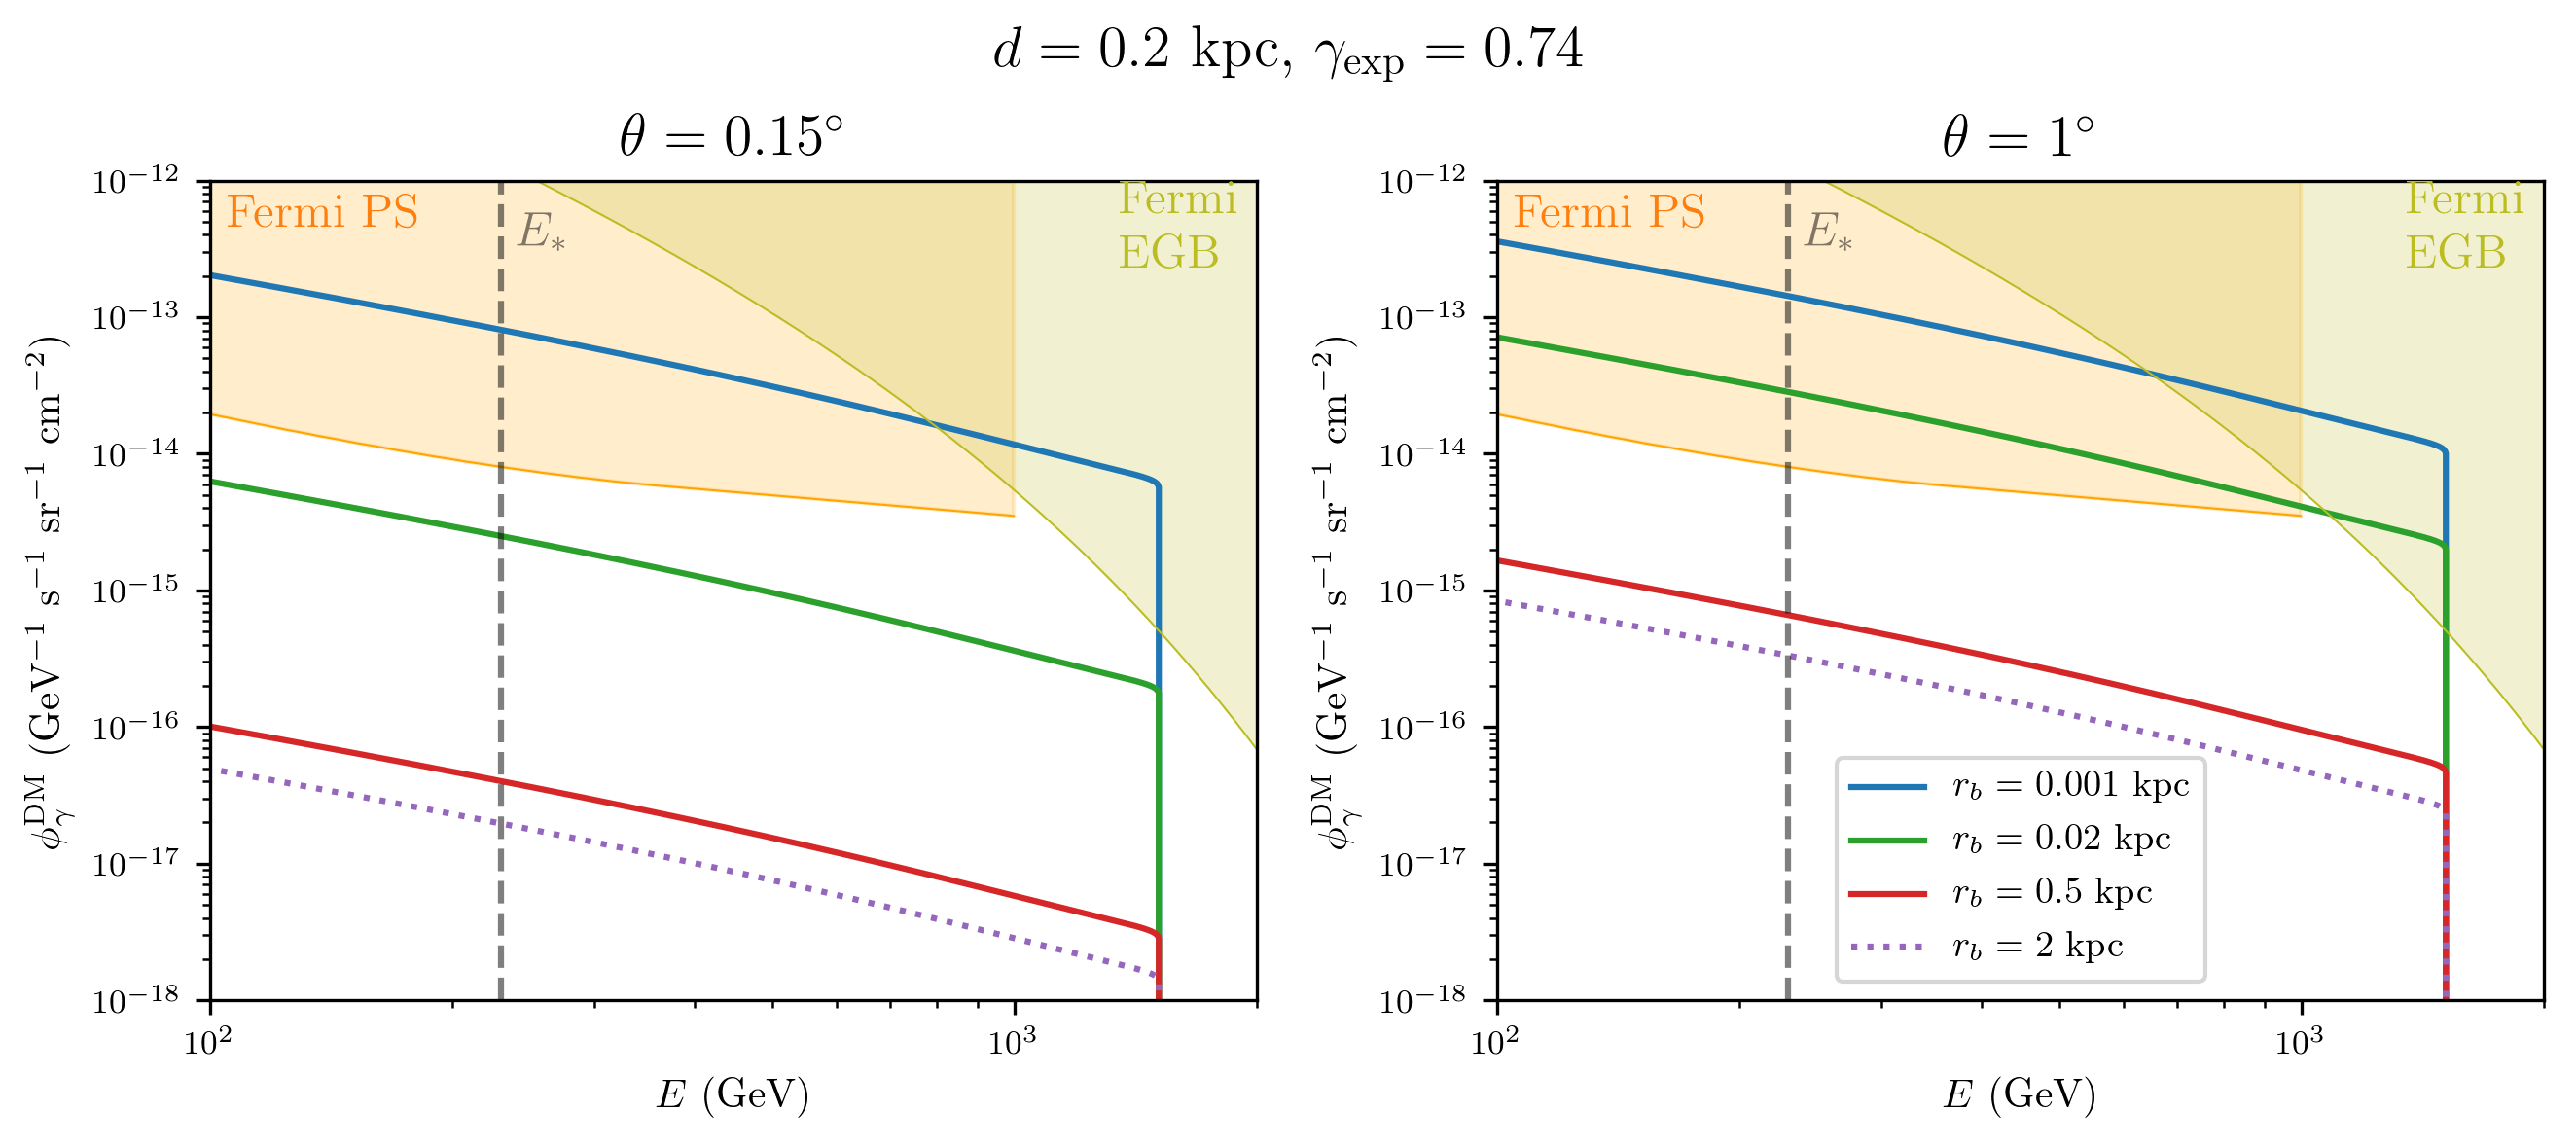

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
power = 0

for th, ax in zip(th_maxes, axs):
    # DM
    for phi, r, lw_ex, c in zip(phi_g_exp[th], r_s, lw_excess, clump_cols):
        if lw_ex > 3.:
            linestyle = ":"
        else:
            linestyle = "-"
        if int(r) == r:
            label = r"$r_b = {}$ kpc".format(int(r))
        else:
            label = r"$r_b = {}$ kpc".format(r)
        ax.plot(e_g, e_g**power * phi,
                color=c, linestyle=linestyle, label=label)
    
    # Fermi
    ax.fill_between(e_g, e_g**power * fermi_pt_src_sens_120_45(e_g), np.ones_like(e_g),
                    color="orange", alpha=0.2, linewidth=1)
    ax.plot(e_g, e_g**power * fermi_pt_src_sens_120_45(e_g), "orange", linewidth=0.5)
    ax.fill_between(e_g, e_g**power * phi_g_egb_fermi(e_g), np.ones_like(e_g),
                    color=colors[8], alpha=0.2, linewidth=0)
    ax.plot(e_g, e_g**power * phi_g_egb_fermi(e_g), colors[8], linewidth=0.5)
    
    # Formatting
    ax.axvline(230, color='k', linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 2e3)
    ax.set_ylim(1e-18, 1e-12)
    ax.set_xlabel(r"$E$ (GeV)")
    ax.set_ylabel(r"$\phi_{\gamma}^{\rm DM}$ (GeV$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")
    ax.text(1.05e2, 4.5e-13, "Fermi PS", color=colors[1])
    ax.text(1350, 2.3e-13, "Fermi\nEGB", color=colors[8])
    ax.text(240, 3e-13, r"$E_*$", alpha=0.5)

# axs[0].legend(loc="center left")
axs[1].legend()#loc="lower left")
axs[0].set_title(r"$\theta = 0.15^\circ$")
axs[1].set_title(r"$\theta = 1^\circ$")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig("figures/gamma_spectra_constraints_exp.pdf")

In [15]:
os.system("say 'done'")

0

#### Checking galactic background

In [10]:
e_fgdil, flux_fgdil = np.loadtxt("data/fermi/galactic_diffuse_intermediate_latitudes.csv").T
e_fgdil /= 1e3
flux_fgdil /= 1e3
flux_fgdil /= e_fgdil**2

In [16]:
1e-3/1e6**2 * 1e3

1e-12

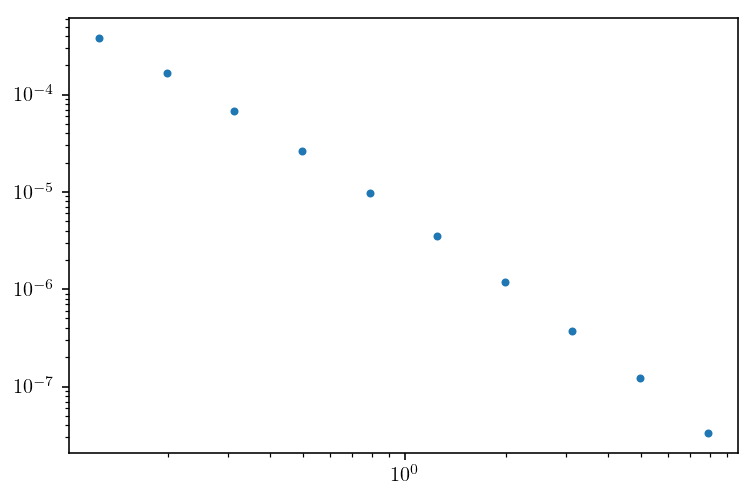

In [12]:
plt.loglog(e_fgdil, e_fgdil**power * flux_fgdil, '.')

### GC flux from DM

Flux from DM annihilating in the GC. This is quite subdominant to the flux from the clump.

In [3]:
rho_s_mw = 0.184
r_s_mw = 24.42
gamma_mw = 1.

phi_g(1.5e3, 8.5, r_s_mw, rho_s_mw, gamma_mw, "nfw", th_max=fermi_psf)

array(3.86814929e-18)

# Scratch

In [162]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

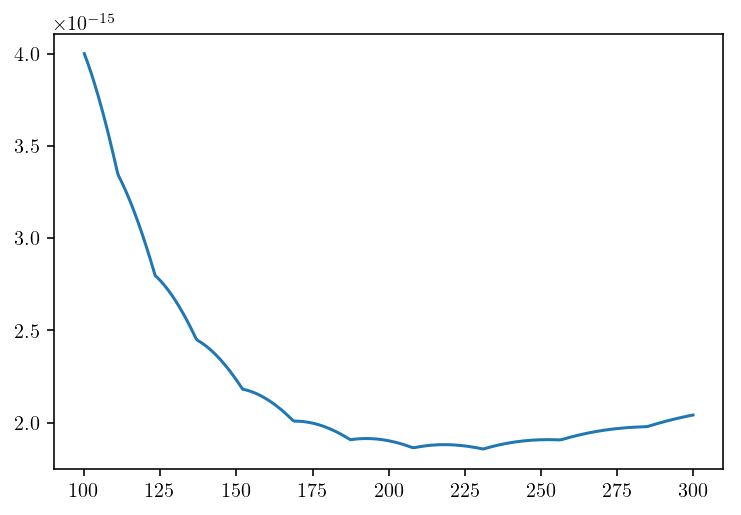

In [173]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - phi)

In [169]:
dm_g_interp = interp1d(e_g, phi)
fermi_sensitivity_interp = interp1d(e_g_f, phi_g_f, bounds_error=False)

In [168]:
minimize_scalar(lambda e: fermi_sensitivity_interp(e) - dm_g_interp(e), bracket=(100, 200, 299))

     fun: 1.8561561777316065e-15
    nfev: 33
     nit: 29
 success: True
       x: 231.00999984255506

(1e-15, 3e-15)

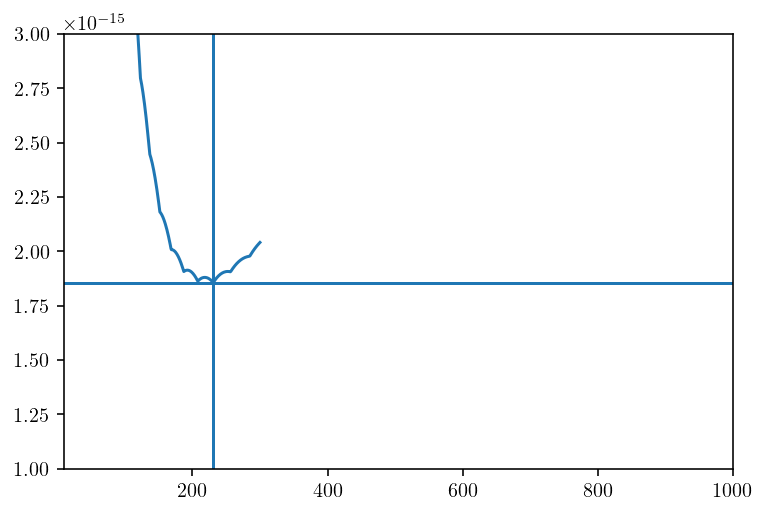

In [174]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - phi)
plt.axvline(230)
plt.axhline(1.8558198565093894e-15)
# plt.plot(e_g_f, phi_g_f, '--k')
plt.xlim(1e1, 1e3)
plt.ylim(1e-15, 3e-15)

How to set a point source constraint with Fermi:
1. Find $E_*$, the energy where the gamma-ray spectrum first touches Fermi's sensitivity curve. Since the DM mass is held fixed at ~1.5 TeV and the spectrum is always the AP one, this is fixed in our analysis. Turns out $E_* \approx 230$ GeV.
2. Get $\phi_\gamma^{\rm DM}(E_*)$ for the clump with $\rho_s = 1$ by integrating over the angular region for a point source.
3. Since $\phi_\gamma^{\rm DM}(E_*) \propto \rho_s^2$, under the assumption the clump was not detected the Fermi constraint on $\rho_s$ is

$$\rho_s \leq \sqrt{\phi_\gamma^{\rm Fermi} / \phi_\gamma^{\rm DM}}.$$

In [113]:
1e-2/2.5e-3

4.0